# Echo metrics of time series

In [1]:
import os
import glob
from collections import defaultdict
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tsnmf

## Load low-rank MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [3]:
low_rank

<xarray.DataArray 'low_rank' (date: 62, frequency: 3, depth: 37, hour: 144)>
[991008 values with dtype=float64]
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83

In [4]:
low_rank_reshape = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank_reshape - low_rank_reshape.min()
low_rank_nonneg.shape

(62, 15984)

## Stack date and hour

In [6]:
low_rank_flat = low_rank.stack(datehour=['date','hour']).reset_index('datehour')

In [7]:
low_rank_flat

<xarray.DataArray 'low_rank' (frequency: 3, depth: 37, datehour: 8928)>
array([[[-62.81310474, -63.01236654, -63.05589541, ..., -66.98229486,
         -67.54693905, -67.75140479],
        [-60.59615528, -59.8954308 , -59.98109702, ..., -66.51235436,
         -67.08250181, -67.17347871],
        [-60.6282189 , -60.0276286 , -60.33801631, ..., -66.75140203,
         -66.91739292, -67.44671165],
        ...,
        [-72.15688845, -72.57027451, -70.80983184, ..., -75.77094197,
         -76.38493006, -76.10818309],
        [-72.03361952, -71.65862923, -72.53667739, ..., -75.39128614,
         -75.2792459 , -76.30096054],
        [-71.80376454, -71.79081764, -70.92733798, ..., -74.87720874,
         -75.69178981, -75.13169525]],

       [[-49.59153314, -50.34532584, -50.99018432, ..., -54.95393525,
         -55.2247343 , -55.63545543],
        [-50.45368749, -49.18998703, -49.22589645, ..., -55.22146036,
         -56.70689158, -56.57009822],
        [-50.13091292, -50.09173639, -50.18732504, ..., -56.83802488,
         -57.14110842, -57.33681329],
        ...,
        [-69.72757802, -68.55490561, -68.16979434, ..., -72.40030007,
         -72.72727839, -72.44606464],
        [-67.79843721, -68.70435453, -69.27235183, ..., -71.83593892,
         -72.70222015, -72.66590689],
        [-66.72198132, -68.06507166, -67.00254508, ..., -69.43971864,
         -69.50284806, -70.04764576]],

       [[-50.5747242 , -50.93656189, -50.94358394, ..., -54.38246551,
         -55.11851976, -55.29347348],
        [-50.29039426, -49.03666546, -49.4039079 , ..., -54.86934753,
         -55.93507174, -55.62605538],
        [-50.41953987, -50.72750871, -50.74361931, ..., -55.45117413,
         -56.2216539 , -56.74508934],
        ...,
        [-72.18495709, -71.17300623, -70.74227787, ..., -75.27981781,
         -75.24689342, -74.93268443],
        [-71.03188173, -71.52117964, -71.59991681, ..., -75.27675588,
         -75.48451915, -75.60578672],
        [-68.34113313, -69.69218692, -68.23347527, ..., -69.50961568,
         -69.32590599, -69.11917311]]])
Coordinates:
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
    date       (datehour) datetime64[ns] 2015-08-17 2015-08-17 ... 2015-10-17
    hour       (datehour) float64 0.0 0.1667 0.3333 0.5 ... 23.5 23.67 23.83
Dimensions without coordinates: datehour

## Plotting functions

In [8]:
def check_time_series(var):
    fig,ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].plot(var.values.T)
    ax[1].plot(var.coarsen(datehour=144).mean().values.T)
    ax[0].set_title('all "pixels" (144 bins/day)')
    ax[1].set_title('daily rolling')
    ax[1].legend(['38 kHz', '120 kHz', '200 kHz'], 
                 fontsize=10, labelspacing=.4)
    ax[1].set_ylim(ax[0].get_ylim())
    plt.show()

In [9]:
def check_distance_matrix(var):
    fig,ax = plt.subplots(1,2,figsize=(8,4))

    D = pdist(var.rolling(datehour=144).mean().values.T, 'euclidean')
    D = (D-np.nanmin(D))/(np.nanmax(D)-np.nanmin(D))
    ax[0].imshow(squareform(D), cmap='RdYlBu', interpolation='none')
    ax[0].set_title('all "pixels" (144 bins/day)')

    D = pdist(var.coarsen(datehour=144).mean().values.T, 'euclidean')
    D = (D-np.nanmin(D))/(np.nanmax(D)-np.nanmin(D))
    ax[1].imshow(squareform(D), cmap='RdYlBu', interpolation='none')
    ax[1].set_title('daily rolling')

    plt.show()

## Echo metrics

Below we calculate 5 echo metrics that were designed to capture the vertical distribution of organisms in the water column:

- area backscattering strength (abundance)
- location (center of mass)
- dispersion (inertia)
- evenness (equivalent area)
- aggregation (index of aggregation)

These metrics were defined in [Urmy et al. 2012. Measuring the vertical distributional variability of pelagic fauna in Monterey Bay. ICES JMS 69(2):184-196.](https://academic.oup.com/icesjms/article/69/2/184/701699)

In [10]:
from scipy.spatial.distance import pdist, squareform

### Area backscattering strength (abundance)

Abundance: Area-backscattering strength [unit: dB re 1 m$^{-1}$]

$
S_a = 10 \log_{10} (\int s_\textrm{V} (z) dz),
$

where $z$ is depth.

In [11]:
del_depth = np.abs(low_rank_flat.depth.diff(dim='depth').mean().values)

In [12]:
sv = 10**(low_rank_flat/10)  # linear domain

In [13]:
sv = sv.assign_coords(depth=sv.depth.values[::-1])  # reverse depth coordinate

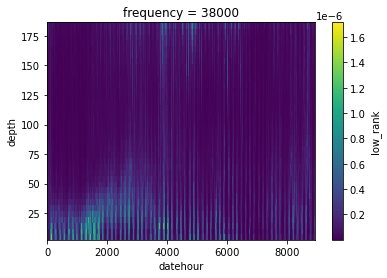

In [14]:
sv.isel(frequency=0).plot()  # sanity check on the depth coordinate

In [15]:
Sa = 10*np.log10((sv * del_depth).sum(dim='depth'))  # integrate over depth

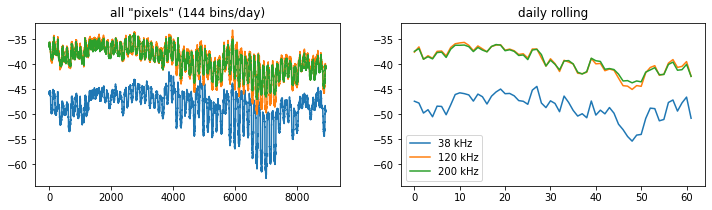

In [16]:
check_time_series(Sa)

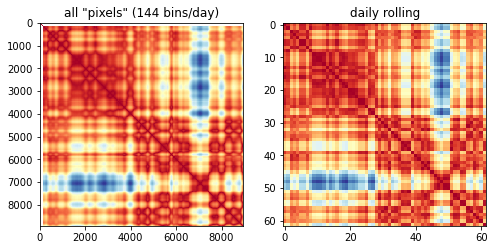

In [17]:
check_distance_matrix(Sa)

### Location (center of mass)

Centre of mass [unit: m]

$
CM = \dfrac{ \int z s_\textrm{V}(z) dz }{ \int s_\textrm{V}(z) dz }
$

In [18]:
cm = (
    (sv.depth * sv * del_depth).sum(dim='depth')/ 
    (sv * del_depth).sum(dim='depth')
    )

In [19]:
cm

<xarray.DataArray (frequency: 3, datehour: 8928)>
array([[40.86037253, 39.96074781, 40.09272777, ..., 50.64062567,
        51.35315935, 51.2974558 ],
       [23.57181484, 23.24369027, 23.67715565, ..., 31.94431827,
        33.05433681, 33.47381527],
       [22.99736843, 22.76372886, 23.12455115, ..., 26.92851961,
        28.3637115 , 28.79294921]])
Coordinates:
  * frequency  (frequency) int64 38000 120000 200000
    date       (datehour) datetime64[ns] 2015-08-17 2015-08-17 ... 2015-10-17
    hour       (datehour) float64 0.0 0.1667 0.3333 0.5 ... 23.5 23.67 23.83
Dimensions without coordinates: datehour

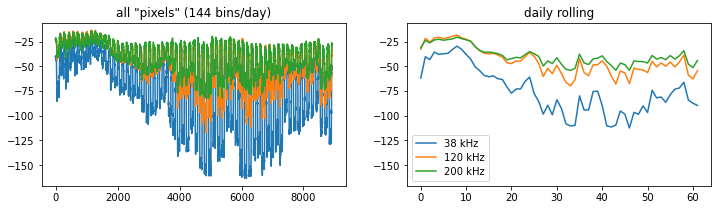

In [20]:
check_time_series(-cm)

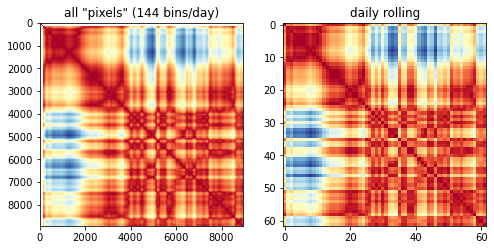

In [21]:
check_distance_matrix(cm)

### Dispersion (inertia)

Inertia [unit: m$^{-2}$]

$
I = \dfrac{ \int (z-CM)^2 s_\textrm{V}(z) dz }{ \int s_\textrm{V}(z) dz }
$

In [22]:
inertia = ( 
    ((sv.depth - cm)**2 * sv * del_depth).sum(dim='depth') / 
    (sv * del_depth).sum(dim='depth')
          )

In [23]:
inertia

<xarray.DataArray (frequency: 3, datehour: 8928)>
array([[2228.38158718, 2222.78599998, 2234.66491672, ..., 2165.31881189,
        2150.89963624, 2107.22200845],
       [ 918.97594158,  883.80243053,  900.56416326, ..., 1261.26570112,
        1281.62650073, 1226.83903132],
       [ 736.0571333 ,  728.16205559,  742.63279055, ...,  936.90923406,
        1013.39076987,  984.29487614]])
Coordinates:
  * frequency  (frequency) int64 38000 120000 200000
    date       (datehour) datetime64[ns] 2015-08-17 2015-08-17 ... 2015-10-17
    hour       (datehour) float64 0.0 0.1667 0.3333 0.5 ... 23.5 23.67 23.83
Dimensions without coordinates: datehour

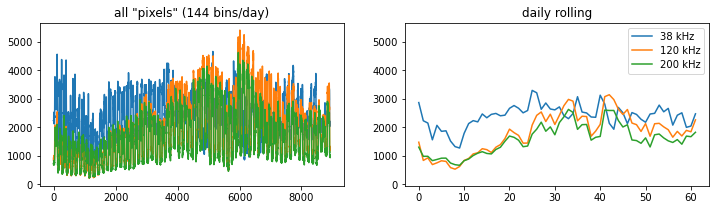

In [24]:
check_time_series(inertia)

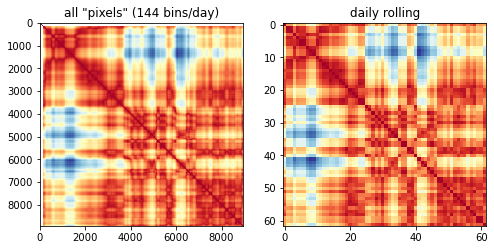

In [25]:
check_distance_matrix(inertia)

### Evenness (equivalent area) and aggregation (index of aggregation)

Equivalent area [unit: m]

$
EA = \dfrac{ ( \int s_\textrm{V}(z) dz )^2 }{ \int s_\textrm{V}(z)^2 dz }
$

Index of aggregation [unit: m$^{-1}$]

$
IA = \dfrac{1}{EA}
$

In [26]:
ea = (
    ((sv * del_depth).sum(dim='depth'))**2 /
    (sv**2 * del_depth).sum(dim='depth')
    )

In [27]:
ia = 1/ea

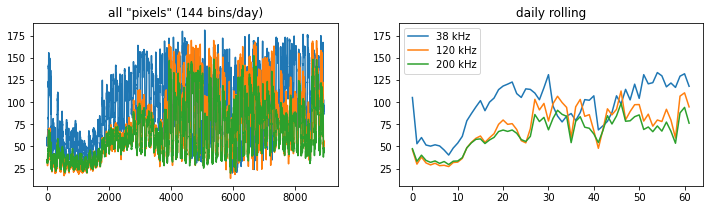

In [28]:
check_time_series(ea)

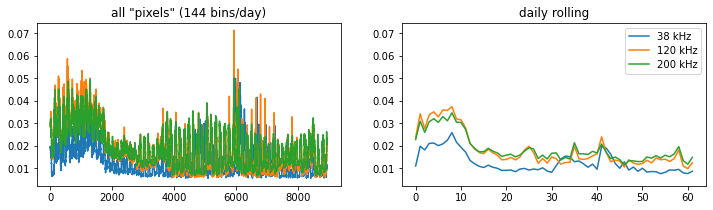

In [29]:
check_time_series(ia)

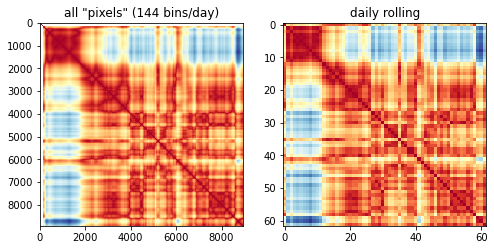

In [30]:
check_distance_matrix(ea)

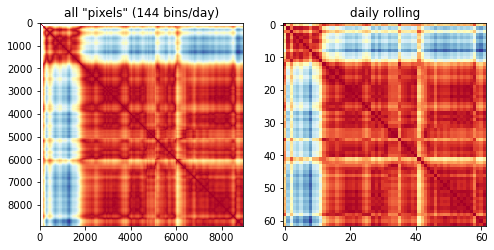

In [31]:
check_distance_matrix(ia)

## tsNMF decomposition

From previous analysis we selected the tsNMF run at rank=3 with `random_seed=1190`. Here we use this initial condition to perform the decomposition again.

In [32]:
model = tsnmf.smoothNMF(n_components=3, 
                        max_iter=2000, 
                        smoothness=500000, 
                        sparsity=0, 
                        early_stopping={'type': 'cost'}
                       )
model.fit(low_rank_nonneg.T, init='random', random_state=1190)

Stopping at iteration 702


We normalize the $\mathbf{W}$ components by its norm and multiply the norm to the $\mathbf{H}$ activations.

In [33]:
H_multW = (model.H.T * np.linalg.norm(model.W, axis=0)).T
W_divW = model.W / np.linalg.norm(model.W, axis=0)

In [34]:
comp_seq_idx = np.array([0,2,1])

Reshape the normalized H and W for plotting:

In [35]:
H_multW.shape, W_divW.shape

((3, 62), (15984, 3))

In [36]:
Ws_reshaped = W_divW[:, comp_seq_idx].T.reshape(3, n_frequencies*n_depth_levels, n_pings)
Hs_reshaped = H_multW[comp_seq_idx, :].T

In [37]:
# Assemble dataset for activation
ds_activation = xr.Dataset(
    {
        'H': (['day', 'component'], Hs_reshaped)
    },
    coords={
        'component': np.arange(3),
        'day': MVBS_rpca['low_rank'].date.values
    }
)

## ADCP data

Here we load ADCP data resampled at 12H intervals.

In [38]:
adcp_file = '../data/ADCP_resample_12H.nc'
ds_mf_resample_12H = xr.open_dataset(adcp_file)

In [39]:
def get_vmax(ds):
    lim_east = float("%2.2f" % np.nanpercentile(
        ds['eastward_seawater_velocity'], 93))
    lim_north = float("%2.2f" % np.nanpercentile(
        ds['northward_seawater_velocity'], 93))
    lim_up = float("%2.2f" % np.nanpercentile(
        ds['upward_seawater_velocity'], 93))
    return max([lim_east, lim_north, lim_up])

In [40]:
def get_v_cuttime(ds):
    vel = dict()
    vel['northsouth'] = ds['northward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    vel['eastwest'] = ds['eastward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    vel['updown'] = ds['upward_seawater_velocity'].\
        sel(time=slice('2015-08-17','2015-10-17')).\
        isel(bin=slice(0,67)).compute()
    
    depth = ds.bin_depths.isel(time=0, bin=slice(0,67)).values
    for vdir in ['northsouth', 'eastwest', 'updown']:
        vel[vdir] = vel[vdir].assign_coords(bin=depth)
        vel[vdir] = vel[vdir].rename({'bin': 'depth'})

    return vel

In [41]:
# Colorbar min max
u_v_w_12H = get_vmax(ds_mf_resample_12H)

In [42]:
# Velocities
vel_12H = get_v_cuttime(ds_mf_resample_12H)

### Velocity profile at 12H resampling interval

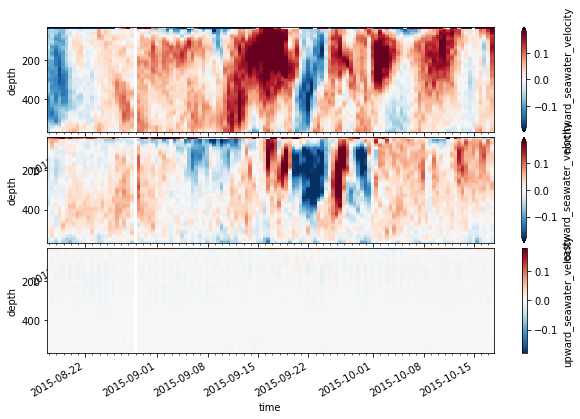

In [43]:
fig, ax = plt.subplots(3,1,figsize=(10,6))
plt.subplots_adjust(hspace=0.05)
for seq,vdir in enumerate(['northsouth', 'eastwest', 'updown']):
    vel_12H[vdir].plot(x='time', ax=ax[seq], vmin=-u_v_w_12H, vmax=u_v_w_12H, cmap='RdBu_r', yincrease=False)
    ax[seq].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
plt.show()

## Fig. S6

Put together time series of echo metrics with ocean currents.

In [44]:
# Construct dataset for convenient plotting
metrics = xr.Dataset(
    {
        'abundance': (['day', 'frequency'], Sa.coarsen(datehour=144).mean().values.T),
        'location': (['day', 'frequency'], cm.coarsen(datehour=144).mean().values.T),
        'dispersion': (['day', 'frequency'], inertia.coarsen(datehour=144).mean().values.T),
        'evenness': (['day', 'frequency'], ea.coarsen(datehour=144).mean().values.T),
    },
    coords={
        'frequency': [38e3, 120e3, 200e3],
        'day': MVBS_rpca['low_rank'].date.values
    }
)

In [45]:
metrics

<xarray.Dataset>
Dimensions:     (day: 62, frequency: 3)
Coordinates:
  * frequency   (frequency) float64 3.8e+04 1.2e+05 2e+05
  * day         (day) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
Data variables:
    abundance   (day, frequency) float64 -47.4 -37.57 -37.42 ... -42.42 -42.42
    location    (day, frequency) float64 61.96 32.69 31.35 ... 89.72 54.46 44.2
    dispersion  (day, frequency) float64 2.866e+03 1.479e+03 ... 1.826e+03
    evenness    (day, frequency) float64 105.1 46.34 47.48 ... 117.8 94.6 76.24

In [46]:
import datetime
import matplotlib.dates as mdates
import matplotlib.colors as colors

In [47]:
# Set date locator and formatter to use with plt.plot_dates
date1 = datetime.datetime(2015, 8, 17, 0, 0, 0)
date2 = datetime.datetime(2015, 10, 17, 23, 59, 59)
locator = mdates.AutoDateLocator().get_locator(date1, date2)
formatter = mdates.AutoDateFormatter(locator)
(type(locator), type(formatter))

x_lims = mdates.date2num([date1, date2])
y_lims = mdates.date2num([date1, date2])

In [48]:
title_size = 12
panel_label_size = 14
tick_label_size = 10
ylabel_size = 10
current_label_size = 12
pad_size = 0

In [49]:
def plot_ADCP_currents(colormap='RdBu_r'):
    # ADCP N-S
    im = vel_12H['northsouth'].plot(x='time',ax=ax_nv,
            vmin=-0.25, vmax=0.2, 
            cmap=colormap, add_colorbar=False, yincrease=False)
    ax_nv.annotate('North', 
                   xy=(0.78,0.16), xycoords='axes fraction', 
                   fontsize=current_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=0.0))

    # ADCP E-W
    im = vel_12H['eastwest'].plot(x='time',ax=ax_ev,
            vmin=-0.2, vmax=0.2, 
            cmap=colormap, add_colorbar=False, yincrease=False)  #RdBu_r
    ax_ev.annotate('East', 
                   xy=(0.82,0.16), xycoords='axes fraction', 
                   fontsize=current_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=0.0))

    # ADCP y-axis label
    fig.text(x=-0.25, y=0, s='Depth (m)',
             transform=ax_nv.transAxes,
             fontsize=ylabel_size, rotation=90, va='center')

    # Adjust axis labels
    ax_ev.xaxis_date()
    ax_ev.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax_ev.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax_ev.xaxis.set_minor_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=range(32))) 
    ax_nv.set_xticklabels('')
    ax_nv.tick_params(axis='x', which='both', length=0, pad=pad_size)
    plt.setp(ax_ev.get_xticklabels(), fontsize=tick_label_size)
    plt.setp(ax_nv.get_yticklabels(), fontsize=tick_label_size)
    plt.setp(ax_ev.get_yticklabels(), fontsize=tick_label_size)
    
    # Current axes location
    pos_nv = ax_nv.get_position()
    pos_ev = ax_ev.get_position()
    ax_nv.set_position([pos_nv.x0, pos_nv.y0-0.02, pos_nv.width, pos_nv.height])
    ax_ev.set_position([pos_ev.x0, pos_ev.y0-0.025, pos_ev.width, pos_ev.height])
    
    # ADCP colorbar
    pos_nv = ax_nv.get_position()
    pos_ev = ax_ev.get_position()
    cbar_ax = fig.add_axes([pos_nv.x0+pos_nv.width+0.03, 
                            pos_ev.y0, 
                            0.03, pos_nv.y0+pos_nv.height-pos_ev.y0])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cbar_ax)
    cbar.set_ticks(np.arange(-0.2, 0.25, 0.1))
    cbar.ax.tick_params(labelsize=tick_label_size) 
    cbar.ax.set_ylabel('Velocity (m/s)', rotation=90, fontsize=ylabel_size)

    ax_nv.set_title('Ocean currents', fontsize=title_size)
    plt.setp(ax_nv.get_xticklabels(), visible=False)
    ax_nv.set_xlabel('')
    ax_ev.set_xlabel('Time', fontsize=ylabel_size)
    ax_nv.set_ylabel('')
    ax_ev.set_ylabel('')

In [50]:
def plot_metrics(axx, var_name, yincrease=True):
    cc = [[0.8, 0.8, 0.8],
          [0.5, 0.5, 0.5],
          [0.2, 0.2, 0.2]]
    for idx in range(3):
        metrics[var_name].isel(frequency=idx).plot.line(
            ax=axx, x='day', color=cc[idx],
            add_legend=False, _labels=False, 
            xlim=('2015-08-17','2015-10-17'), yincrease=yincrease)        
    axx.xaxis.set_major_locator(mdates.AutoDateLocator())
    axx.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axx.xaxis.set_minor_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=range(32))) 
    axx.set_xticklabels('')
    axx.tick_params(labelsize=tick_label_size) 

In [51]:
def add_panel_labels():
    fig.text(x=-0.15,y=1.3,s='A',
             transform=ax_tsnmf.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')
    fig.text(x=-0.15,y=1.2,s='B',
             transform=ax_abundance.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')
    fig.text(x=-0.15,y=1.1,s='C',
             transform=ax_nv.transAxes,
             fontsize=panel_label_size, fontweight='bold', va='center')

In [52]:
def plot_tsnmf_activation():
    ds_activation['H'].plot.line(
        ax=ax_tsnmf, x='day', add_legend=False, _labels=False, 
        xlim=('2015-08-17','2015-10-17'))
    ax_tsnmf.set_title('tsNMF activations', fontsize=title_size)
    ax_tsnmf.set_ylabel('Relative\nstrength', fontsize=ylabel_size)
    ax_tsnmf.tick_params(labelsize=tick_label_size) 
    ax_tsnmf.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax_tsnmf.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax_tsnmf.xaxis.set_minor_locator(
        mdates.MonthLocator(bymonth=range(8,11), bymonthday=range(32)))
    ax_tsnmf.set_xticklabels('')

In [53]:
from cycler import cycler

In [54]:
cmap = plt.cm.get_cmap('YlGnBu')
plt.rcParams['axes.prop_cycle'] = cycler(color=cmap([0.2,0.5,0.9]))

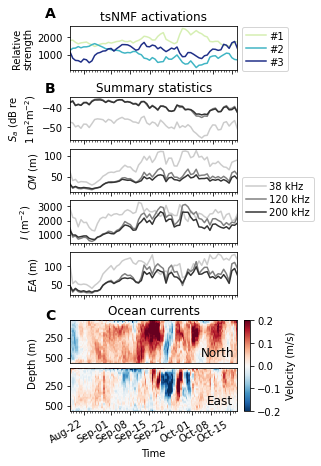

In [55]:
fig = plt.figure(figsize=(3,6.5))

gs = fig.add_gridspec(7, 1)

# Axes for echo metrics
ax_abundance = fig.add_subplot(gs[1, 0])
ax_location = fig.add_subplot(gs[2, 0])
ax_dispersion = fig.add_subplot(gs[3, 0])
ax_evenness = fig.add_subplot(gs[4, 0])

# Axis for tsNMF activation
ax_tsnmf = fig.add_subplot(gs[0, 0])
pos_tsnmf = ax_tsnmf.get_position()
ax_tsnmf.set_position([pos_tsnmf.x0, pos_tsnmf.y0+0.04, 
                       pos_tsnmf.width, pos_tsnmf.height])

# Axes for ADCP
ax_nv = fig.add_subplot(gs[5, 0])
ax_ev = fig.add_subplot(gs[6, 0])
pos_nv = ax_nv.get_position()
pos_ev = ax_ev.get_position()
ax_nv.set_position([pos_nv.x0, pos_nv.y0-0.015, pos_nv.width, pos_nv.height])
ax_ev.set_position([pos_ev.x0, pos_ev.y0-0.002, pos_ev.width, pos_ev.height])

# Plot tsNMF activation
plot_tsnmf_activation()

# Add component legend
ax_tsnmf.legend(['#1', '#2', '#3'], 
                fontsize=tick_label_size,
                bbox_to_anchor=(1, -0.15), 
                loc='lower left', 
                ncol=1, labelspacing=0.3, handletextpad=0.3)

# Plot echo metrics
plot_metrics(axx=ax_abundance, var_name='abundance')
ax_abundance.set_ylabel('$S_a$ (dB re\n1 m$^2$m$^{-2}$)', fontsize=ylabel_size)
plot_metrics(axx=ax_location, var_name='location')
ax_location.set_ylabel('$CM$ (m)', fontsize=ylabel_size)
plot_metrics(axx=ax_dispersion, var_name='dispersion')
ax_dispersion.set_ylabel('$I$ (m$^{-2}$)', fontsize=ylabel_size)
plot_metrics(axx=ax_evenness, var_name='evenness')
ax_evenness.set_ylabel('$EA$ (m)', fontsize=ylabel_size)

ax_abundance.set_title('Summary statistics', fontsize=title_size)
ax_abundance.legend(['38 kHz', '120 kHz', '200 kHz'], 
                fontsize=tick_label_size,
                bbox_to_anchor=(1, -2), 
                loc='lower left', 
                ncol=1, labelspacing=0.3, handletextpad=0.3)

# Plot ADCP currents
plot_ADCP_currents()

# Add panel labels
add_panel_labels()

# Save figure
plt.savefig('../figs/fig_si_summary_stat.png', 
            dpi=300, bbox_inches = 'tight', pad_inches = 0.01)
plt.show()